In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
#Đọc data
df = pd.read_csv('../VCB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)
df = df[['Price']]

In [3]:
df

,Price
Date,
2019-01-02,"41,161"
2019-01-03,"41,161"
2019-01-04,"41,775"
2019-01-07,"41,929"
2019-01-08,"42,236"
...,...
2023-06-12,"101,000"
2023-06-13,"102,500"
2023-06-14,"102,600"


In [4]:
#Xóa dấu , và chuyển về float
df['Price']=df['Price'].replace(',','',regex=True).astype(float)


In [5]:
# 3. Scaler data
scaler=MinMaxScaler()
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [6]:
# 4. Chia train test val theo tỉ lệ 8-1-1
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+39 and Y=t+40
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(40,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1,shuffle=False)

Epoch 1/100
14/14 [==============================] - 55s 988ms/step - loss: 0.0260 - val_loss: 0.0063
Epoch 2/100
14/14 [==============================] - 2s 163ms/step - loss: 0.0081 - val_loss: 0.0109
Epoch 3/100
14/14 [==============================] - 3s 199ms/step - loss: 0.0122 - val_loss: 0.0163
Epoch 4/100
14/14 [==============================] - 2s 160ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 5/100
14/14 [==============================] - 2s 173ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 6/100
14/14 [==============================] - 2s 148ms/step - loss: 0.0049 - val_loss: 0.0062
Epoch 7/100
14/14 [==============================] - 2s 153ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 8/100
14/14 [==============================] - 2s 179ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 9/100
14/14 [==============================] - 3s 211ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 10/100
14/14 [==============================] - 3s 186ms/step - loss: 0.0083 - val_l

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 21ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
yval=scaler.inverse_transform(yval.reshape(-1,1))

In [15]:
# Tính độ đo MDA trên tập test
test_actual_direction = np.sign(ytest[1:] - ytest[:-1])
test_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])
test_correct = np.where(test_actual_direction == test_pred_direction, 1, 0)
test_mda = np.mean(test_correct)
# Tính độ đo MDA trên tập validation
val_actual_direction = np.sign(yval[1:] - yval[:-1])
val_pred_direction = np.sign(y_pred_val[1:] - y_pred_val[:-1])
val_correct = np.where(val_actual_direction == val_pred_direction, 1, 0)
val_mda = np.mean(val_correct)

In [16]:
#Tính độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(yval))  # MAPE
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(ytest))  # MAPE
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Validation MDA: {test_mda*100:.2f}")
print(f"Testing MDA: {val_mda*100:.2f}")

Validation RMSE: 2605.95
Testing RMSE: 2859.37
Validation MAPE: 2.26%
Testing MAPE: 3.01%
Validation MDA: 40.58
Testing MDA: 47.14


In [17]:
df = pd.read_csv('../VCB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)

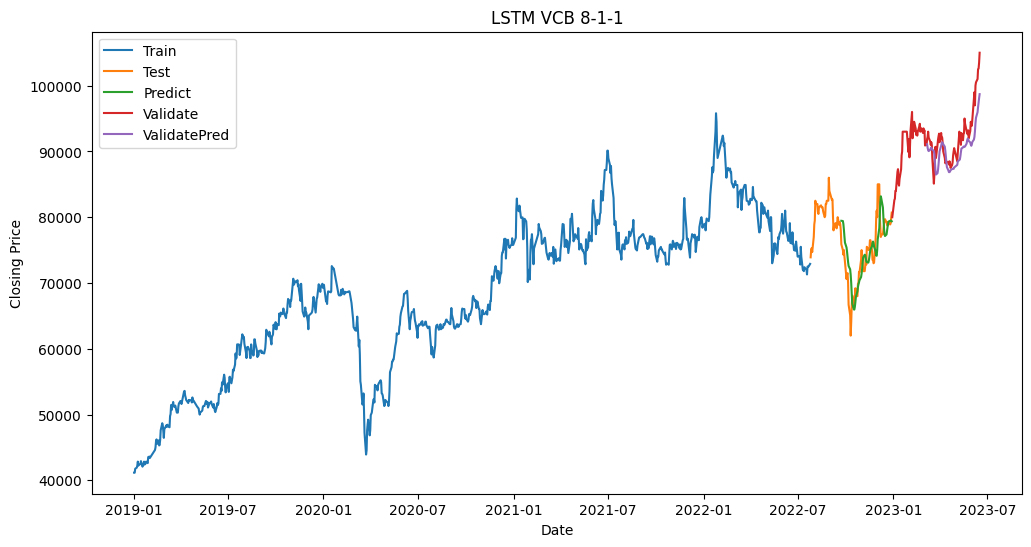

In [18]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('LSTM VCB 8-1-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
#prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()